In [1]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, TrainingArguments, Trainer

tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")

model = AutoModelForQuestionAnswering.from_pretrained("distilbert/distilbert-base-uncased")

c:\Users\yaoji\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [2]:
import pandas as pd
df = pd.read_csv('../question_answer_pair_2.csv')
df_context = pd.read_csv('../abstractive_summaries.csv')
merged_df = pd.merge(df, df_context, on='Topic', how='left')
merged_df

,Topic,TaggedSentence,Answer,Question,Label,Abstractive Summary
0,-1,The [HL] development [HL] of highly immunogeni...,development,What is critical for controlling the COVID-19 ...,pandemic_covid19_infection,The development of highly immunogenic and safe...
1,-1,The development of highly immunogenic and safe...,immunogenic vaccines,The development of highly immunogenic and safe...,pandemic_covid19_infection,The development of highly immunogenic and safe...
2,-1,The development of highly immunogenic and safe...,be critical,What will the development of highly immunogeni...,pandemic_covid19_infection,The development of highly immunogenic and safe...
3,-1,No one [HL] type [HL] of vaccine will likely f...,type,What type of vaccine will likely fill the glob...,pandemic_covid19_infection,The development of highly immunogenic and safe...
4,-1,No one type of [HL] vaccine [HL] will likely f...,vaccine,What type of vaccine will likely fill the glob...,pandemic_covid19_infection,The development of highly immunogenic and safe...
...,...,...,...,...,...,...
1425,155,Half of our [HL] patients [HL] had comorbiditi...,patients,How many patients had comorbidities?,covid19_fever_pneumonia,The first Covid-19 listed studies with pediatr...
1426,155,Half of our patients [HL] had [HL] comorbiditi...,had,Half of our patients had what type of comorbid...,covid19_fever_pneumonia,The first Covid-19 listed studies with pediatr...
1427,155,The long-[HL] term impact [HL] of neurological...,term impact,What is uncertain about the long term impact o...,covid19_fever_pneumonia,The first Covid-19 listed studies with pediatr...
1428,155,The long-term impact of [HL] neurological dama...,neurological damage,What is uncertain about the long-term impact o...,covid19_fever_pneumonia,The first Covid-19 listed studies with pediatr...


In [3]:
merged_df = merged_df.rename(columns={"Answer": "answers", "Question" : "question", "Abstractive Summary" : "context"})

# Convert the updated DataFrame to a list of dictionaries for question-answering
qa_data_cleaned = merged_df[['question', 'answers', 'context']]

In [4]:
qa_data_cleaned['answers'] = qa_data_cleaned['answers'].astype(str)
qa_data_cleaned['question'] = qa_data_cleaned['question'].astype(str)
qa_data_cleaned['context'] = qa_data_cleaned['context'].astype(str)

C:\Users\yaoji\AppData\Local\Temp\ipykernel_24440\2725166270.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qa_data_cleaned['answers'] = qa_data_cleaned['answers'].astype(str)
C:\Users\yaoji\AppData\Local\Temp\ipykernel_24440\2725166270.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qa_data_cleaned['question'] = qa_data_cleaned['question'].astype(str)
C:\Users\yaoji\AppData\Local\Temp\ipykernel_24440\2725166270.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

In [5]:
import pandas as pd

# Assuming df is your pandas DataFrame

# Define a function to find the start position of the answer in the context
def find_answer_start(context, answer):
    return context.find(answer)

# Adjust the 'answers' column to match the expected structure
qa_data_cleaned['answers'] = qa_data_cleaned.apply(lambda row: {'text': [row['answers']], 'answer_start': [find_answer_start(row['context'], row['answers'])]}, axis=1)

# Show the updated DataFrame
qa_data_cleaned

C:\Users\yaoji\AppData\Local\Temp\ipykernel_24440\775699054.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qa_data_cleaned['answers'] = qa_data_cleaned.apply(lambda row: {'text': [row['answers']], 'answer_start': [find_answer_start(row['context'], row['answers'])]}, axis=1)


,question,answers,context
0,What is critical for controlling the COVID-19 ...,"{'text': ['development'], 'answer_start': [4]}",The development of highly immunogenic and safe...
1,The development of highly immunogenic and safe...,"{'text': ['immunogenic vaccines'], 'answer_sta...",The development of highly immunogenic and safe...
2,What will the development of highly immunogeni...,"{'text': ['be critical'], 'answer_start': [61]}",The development of highly immunogenic and safe...
3,What type of vaccine will likely fill the glob...,"{'text': ['type'], 'answer_start': [119]}",The development of highly immunogenic and safe...
4,What type of vaccine will likely fill the glob...,"{'text': ['vaccine'], 'answer_start': [47]}",The development of highly immunogenic and safe...
...,...,...,...
1425,How many patients had comorbidities?,"{'text': ['patients'], 'answer_start': [49]}",The first Covid-19 listed studies with pediatr...
1426,Half of our patients had what type of comorbid...,"{'text': ['had'], 'answer_start': [108]}",The first Covid-19 listed studies with pediatr...
1427,What is uncertain about the long term impact o...,"{'text': ['term impact'], 'answer_start': [224]}",The first Covid-19 listed studies with pediatr...
1428,What is uncertain about the long-term impact o...,"{'text': ['neurological damage'], 'answer_star...",The first Covid-19 listed studies with pediatr...


In [6]:
def preprocess_function(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=384,
        truncation="only_second",
        return_offsets_mapping=True,
        padding="max_length",
    )

    offset_mapping = inputs.pop("offset_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        answer = answers[i]
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context, label it (0, 0)
        if offset[context_start][0] > end_char or offset[context_end][1] < start_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

In [7]:
from datasets import Dataset
data_dicts = qa_data_cleaned.to_dict('records')
dataset = Dataset.from_pandas(pd.DataFrame(data_dicts))
dataset = dataset.train_test_split(test_size=0.2)

tokenized_dataset = dataset.map(preprocess_function, batched=True, remove_columns=['question', 'answers', 'context'])

Map:   0%|          | 0/1144 [00:00<?, ? examples/s]

Map: 100%|██████████| 286/286 [00:00<00:00, 3466.41 examples/s]


In [8]:
from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding

# Initialize the data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

# Assuming `tokenized_dataset` is your DatasetDict after applying preprocess_function

# Convert the 'train' and 'test' splits to PyTorch DataLoader
train_dataloader = DataLoader(
    tokenized_dataset["train"],
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator,
)

validation_dataloader = DataLoader(
    tokenized_dataset["test"],
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator,
)

In [10]:
from transformers import AutoModelForQuestionAnswering, TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="my_awesome_qa_model",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.0001,
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)



In [11]:
trainer.train()

                                                  
 10%|█         | 72/720 [07:53<54:56,  5.09s/it]

{'eval_loss': 3.167964458465576, 'eval_runtime': 39.494, 'eval_samples_per_second': 7.242, 'eval_steps_per_second': 0.456, 'epoch': 1.0}


                                                   
 20%|██        | 144/720 [15:44<48:37,  5.07s/it]

{'eval_loss': 2.5376968383789062, 'eval_runtime': 39.402, 'eval_samples_per_second': 7.259, 'eval_steps_per_second': 0.457, 'epoch': 2.0}


                                                   
 30%|███       | 216/720 [23:33<42:33,  5.07s/it]

{'eval_loss': 2.396631956100464, 'eval_runtime': 39.34, 'eval_samples_per_second': 7.27, 'eval_steps_per_second': 0.458, 'epoch': 3.0}


                                                   
 40%|████      | 288/720 [31:22<36:45,  5.10s/it]

{'eval_loss': 2.4326701164245605, 'eval_runtime': 39.312, 'eval_samples_per_second': 7.275, 'eval_steps_per_second': 0.458, 'epoch': 4.0}


                                                   
 50%|█████     | 360/720 [39:11<30:29,  5.08s/it]

{'eval_loss': 2.5335865020751953, 'eval_runtime': 39.301, 'eval_samples_per_second': 7.277, 'eval_steps_per_second': 0.458, 'epoch': 5.0}


                                                   
 60%|██████    | 432/720 [47:00<24:20,  5.07s/it]

{'eval_loss': 2.621722936630249, 'eval_runtime': 39.4769, 'eval_samples_per_second': 7.245, 'eval_steps_per_second': 0.456, 'epoch': 6.0}


 69%|██████▉   | 500/720 [53:49<22:06,  6.03s/it]  Checkpoint destination directory my_awesome_qa_model\checkpoint-500 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'loss': 2.1486, 'learning_rate': 6.111111111111112e-06, 'epoch': 6.94}


                                                 
 70%|███████   | 504/720 [54:50<18:39,  5.18s/it]

{'eval_loss': 2.8128652572631836, 'eval_runtime': 40.008, 'eval_samples_per_second': 7.149, 'eval_steps_per_second': 0.45, 'epoch': 7.0}


                                                   
 80%|████████  | 576/720 [1:02:50<12:37,  5.26s/it]

{'eval_loss': 2.965693473815918, 'eval_runtime': 41.07, 'eval_samples_per_second': 6.964, 'eval_steps_per_second': 0.438, 'epoch': 8.0}


                                                   
 90%|█████████ | 648/720 [1:10:43<06:17,  5.25s/it]

{'eval_loss': 2.981513500213623, 'eval_runtime': 39.548, 'eval_samples_per_second': 7.232, 'eval_steps_per_second': 0.455, 'epoch': 9.0}


                                                   
100%|██████████| 720/720 [1:18:28<00:00,  6.54s/it]

{'eval_loss': 3.0148515701293945, 'eval_runtime': 39.368, 'eval_samples_per_second': 7.265, 'eval_steps_per_second': 0.457, 'epoch': 10.0}
{'train_runtime': 4708.2905, 'train_samples_per_second': 2.43, 'train_steps_per_second': 0.153, 'train_loss': 1.8048279444376627, 'epoch': 10.0}


TrainOutput(global_step=720, training_loss=1.8048279444376627, metrics={'train_runtime': 4708.2905, 'train_samples_per_second': 2.43, 'train_steps_per_second': 0.153, 'train_loss': 1.8048279444376627, 'epoch': 10.0})

In [13]:
import torch
torch.save(model.state_dict(), '../model/model_weights_5.pth')

In [14]:
model = AutoModelForQuestionAnswering.from_pretrained("distilbert/distilbert-base-uncased")
model.load_state_dict(torch.load('../model/model_weights_5.pth'))
model.eval()

Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForQuestionAnswering(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
      

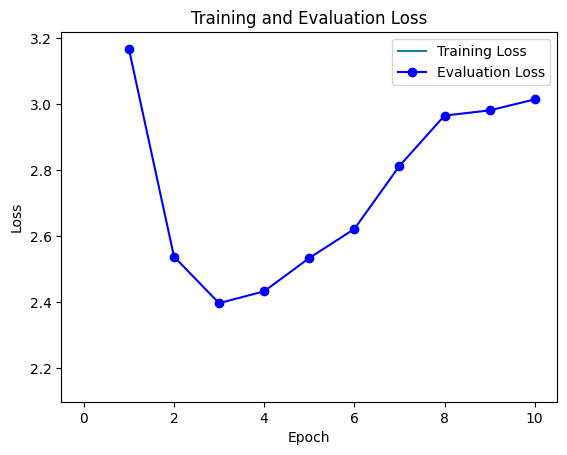

In [15]:
train_losses = [log['loss'] for log in trainer.state.log_history if 'loss' in log and 'eval_loss' not in log]
eval_losses = [log['eval_loss'] for log in trainer.state.log_history if 'eval_loss' in log]
eval_metrics = [log for log in trainer.state.log_history if 'eval_loss' in log]  # Includes all eval metrics

import matplotlib.pyplot as plt

# Plot training loss
plt.plot(train_losses, label='Training Loss')

# Since evaluation might happen less frequently, you might want to note these points specifically
epochs = range(1, len(eval_losses) + 1)
plt.plot(epochs, eval_losses, 'bo-', label='Evaluation Loss')

plt.title('Training and Evaluation Loss')
plt.xlabel('Step' if len(train_losses) > len(epochs) else 'Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [18]:
question = "What causes the creation of new routes for drug trafficking?"
context = "More than 35 million people worldwide are currently addicted to drugs. COVID-19 has created new routes for drug trafficking that increase the risk of drug addiction, making it vital to address this problem. The aim is to effectively protect the physical health of PWUD and prevent the combination of COVID-19 and the physiological and psychological effects of drugs from affecting relapse behaviour."

In [19]:
from transformers import pipeline

question_answerer = pipeline("question-answering", model=model, tokenizer=tokenizer)
question_answerer(question=question, context=context)

{'score': 0.4343598783016205, 'start': 71, 'end': 79, 'answer': 'COVID-19'}